# Analyze Ball on Incline data
Use this notebook to quickly test whether your ball on incline data makes sense!

In [223]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

## Reading the data

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

In [224]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

def find_midpoints(time, voltage, show_plot=False, show_zoomed_plot=False):
    """Find timing of ball crossings"""
    
    
    # Write a function yourself, which identifies the peaks in the voltage,
    # and returns values for passing times and (possibly) their uncertainties
    # in it (but they are generally very small!).

    time = np.array(time)
    voltage = np.array(voltage)

    threshold = 0.5 * (np.max(voltage) + np.min(voltage))

    # 2. Boolean mask: True while peak is high
    high = voltage > threshold

    # 3. Find rising and falling edges of the high regions
    edges = np.diff(high.astype(int))

    start_indices = np.where(edges == +1)[0] + 1   # rising edges
    end_indices   = np.where(edges == -1)[0]       # falling edges

    # Handle case where signal starts or ends high
    if high[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if high[-1]:
        end_indices = np.append(end_indices, len(high)-1)

    # 4. Compute center times for each peak
    peak_centers = (time[start_indices] + time[end_indices]) / 2
    
    peak_widths = time[end_indices] - time[start_indices]
    # sigma_width = peak_widths / (2 * np.sqrt(12))

    # Sampling resolution uncertainty
    # dt = np.mean(np.diff(time))
    # sigma_sampling = dt / 2

    # Conservative choice
    # t_pass_sigma = np.maximum(sigma_width, sigma_sampling)
    # t_pass_sigma = np.full_like(peak_centers, 0.0001)
    # sigma = np.full_like(peak_centers, peak_widths / np.sqrt(12))
    # sigma_on_the_mean = sigma / np.sqrt(len((time[start_indices] + time[end_indices])))
    # t_pass_sigma = sigma_on_the_mean
    sigma = peak_widths / np.sqrt(12)
    N = end_indices - start_indices + 1
    sigma_mean = sigma / np.sqrt(N)
    t_pass_sigma = sigma_mean

    t_pass = np.array(peak_centers)
     
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(time, voltage, marker='o', linestyle='None',markersize = 4,alpha =0.8,label='Voltage signal')
        plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
        plt.scatter(t_pass, np.full_like(t_pass, threshold), color='green', label='Detected Passings')
        plt.errorbar(t_pass, np.full_like(t_pass, threshold), yerr=t_pass_sigma, fmt='o', color='green')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.xlim(time[0], .6)
        plt.title('Ball on Incline Voltage Signal with Detected Passings')

        plt.legend()
        plt.show()
    
    if show_zoomed_plot:
        plt.figure(figsize=(10, 6))
        plt.plot(time, voltage, marker='o', label='Voltage signal')
        plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
        # plt.scatter(t_pass, np.full_like(t_pass, threshold), color='green', label='Detected Passings')
        # plt.errorbar(t_pass, np.full_like(t_pass, threshold), yerr=t_pass_sigma, fmt='o', color='green')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.xlim(-0.005, 0.02)
        plt.title('Zoomed-in Ball on Incline Voltage Signal with Detected Passings')
        plt.axvline(t_pass[1]+t_pass_sigma[1], color='blue', linestyle='--', label='+sigma')
        plt.axvline(t_pass[1]-t_pass_sigma[1], color='blue', linestyle='--', label='-sigma')
        plt.axvline(t_pass[1], color='g', linestyle='--', label='Detected Passings')
        plt.legend()
        plt.show()
    


    
    return t_pass, t_pass_sigma

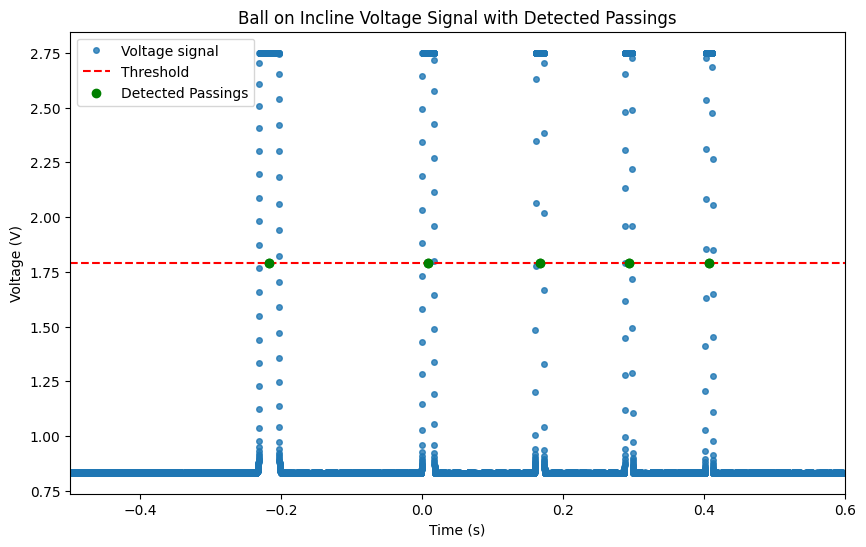

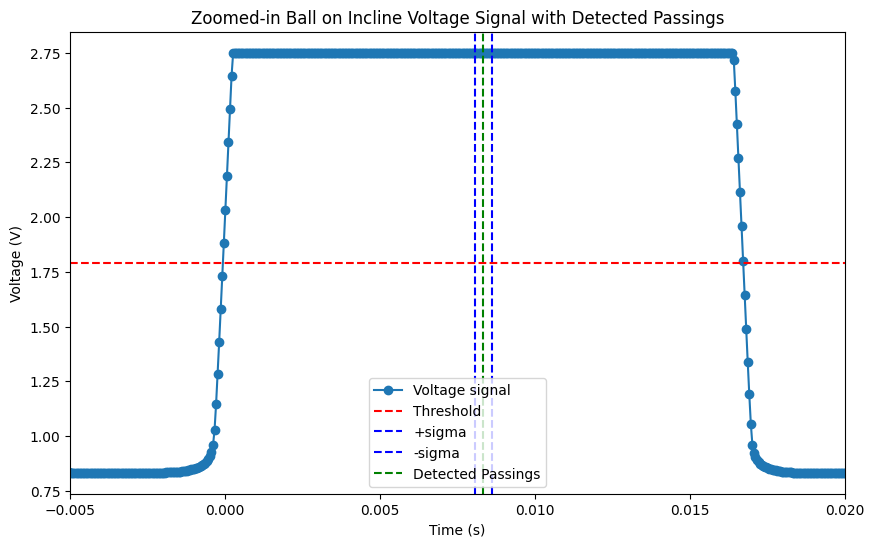

[0.00034157 0.00026379 0.00022127 0.00020917 0.0002031 ]


In [225]:
# Read the data and plot it (possibly with passing times in):
filename = 'ball_big_1.csv'

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage, show_plot=True, show_zoomed_plot=True)
print(timepass_sig)

# fig, ax = plt.subplots(figsize=(14, 6))
# ax.plot(time, voltage, 'k.', label='Measurements')
# ax.set_title("Data from Ball-on-Incline experiment")
# ax.set_xlabel("Time (s)", fontsize=18)
# ax.set_ylabel("Voltage (V)", fontsize=18)


In [226]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
import numpy as np
from scipy import stats

In [227]:
def model(t, a, v0):
    return 0.5 * a * t**2 + v0 * t
def fit(weighted_mean, weighted_mean_err, timepass, timepass_err):
  
    x = weighted_mean - weighted_mean[0]
    t = timepass - timepass[0]  # set t=0 at first passing

    sx_meas = weighted_mean_err

    a_guess = 1.5
    v0_guess = 0.5
    # Propagate time uncertainty into x
    sx_time = np.abs(v0_guess + a_guess * t) * timepass_err

    # Total uncertainty
    sx = np.sqrt(sx_meas**2 + sx_time**2)

    mfit = Minuit(LeastSquares(t, x, sx, model), a=9.81, v0=0.0)
    mfit.migrad()  # perform the minimization
    return mfit




In [228]:
blinded = False          # Add a random (but fixed) offset to the 30cm and 2m data seperately

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)



In [229]:
def weighted_mean(a,s):
    """Compute weighted mean and its uncertainty"""
    a = np.asarray(a, dtype=float)
    s = np.asarray(s, dtype=float)
    w = 1 / s**2
    wmean = np.sum(w * a) / np.sum(w)
    wmean_err = np.sqrt(1 / np.sum(w)) 
    return wmean, wmean_err

In [230]:
def main(filename):
    
        
        
    weighted_mean = np.array([8.45567020250723,23.390549662487942,38.54252651880424 ,53.46890067502411,69.1189006750241  ])*0.01
    # weighted_mean = weighted_mean - weighted_mean[0]
    weighted_mean_err = np.array([0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758])*0.01
    time, voltage = read_csv(filename)
    timepass, timepass_sig = find_midpoints(time, voltage, show_plot=False)
    # timepass = timepass - timepass[0]  # set t=0 at first passing
    
    mfit = fit(weighted_mean, weighted_mean_err, timepass,timepass_sig)
    return mfit

def process_files(file_list):
    """
    Runs main() for each file in file_list,
    returns arrays of a-values and a-errors.
    """
    a_vals = []
    a_errs = []
    for f in file_list:
        mfit = main(f)
        a_vals.append(mfit.values["a"])
        a_errs.append(mfit.errors["a"])
    return np.array(a_vals), np.array(a_errs)
def cross_check(a1, a1_err, a2, a2_err):
    diff = a1 - a2
    diff_err = np.sqrt(a1_err**2 + a2_err**2)
    z_score = diff / diff_err
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # two-tailed p-value
    return z_score, p_value

In [231]:
### FILES ###

big_ball_files = ['ball_big_1.csv', 'ball_big_2.csv', 'ball_big_3.csv', 'ball_big_4.csv', 'ball_big_5.csv', 'ball_big_6.csv', 'ball_big_7.csv', 'ball_big_8.csv']
big_ball_reversed_files = ['ball_big_reversed_1.csv', 'ball_big_reversed_2.csv', 'ball_big_reversed_3.csv', 'ball_big_reversed_4.csv', 'ball_big_reversed_5.csv']

med_balls_files = ['ball_med_1.csv', 'ball_med_2.csv', 'ball_med_3.csv', 'ball_med_4.csv', 'ball_med_5.csv']
med_balls_reversed_files = ['ball_med_reversed_1.csv', 'ball_med_reversed_2.csv', 'ball_med_reversed_3.csv', 'ball_med_reversed_4.csv', 'ball_med_reversed_5.csv']

small_balls_files = ['ball_small_1.csv', 'ball_small_2.csv', 'ball_small_3.csv', 'ball_small_4.csv', 'ball_small_5.csv']
small_balls_reversed_files = ['ball_small_reversed_1.csv', 'ball_small_reversed_2.csv', 'ball_small_reversed_3.csv', 'ball_small_reversed_4.csv', 'ball_small_reversed_5.csv']  

### PROCESSING ###

a_big, a_big_err = process_files(big_ball_files)
a_big_rev, a_big_rev_err = process_files(big_ball_reversed_files)

a_med, a_med_err = process_files(med_balls_files)
a_med_rev, a_med_rev_err = process_files(med_balls_reversed_files)

a_small, a_small_err = process_files(small_balls_files)
a_small_rev, a_small_rev_err = process_files(small_balls_reversed_files)

### WEIGHTED MEANS ###

a_big_wmean, a_big_wmean_err = weighted_mean(a_big, a_big_err)
a_big_rev_wmean, a_big_rev_wmean_err = weighted_mean(a_big_rev, a_big_rev_err)

a_med_wmean, a_med_wmean_err = weighted_mean(a_med, a_med_err)
a_med_rev_wmean, a_med_rev_wmean_err = weighted_mean(a_med_rev, a_med_rev_err)

a_small_wmean, a_small_wmean_err = weighted_mean(a_small, a_small_err)
a_small_rev_wmean, a_small_rev_wmean_err = weighted_mean(a_small_rev, a_small_rev_err)

### CROSS CHECK ###

# REVERSED VS NORMAL 
z_big, p_big = cross_check(a_big_wmean, a_big_wmean_err, a_big_rev_wmean, a_big_rev_wmean_err)
z_med, p_med = cross_check(a_med_wmean, a_med_wmean_err, a_med_rev_wmean, a_med_rev_wmean_err)
z_small, p_small = cross_check(a_small_wmean, a_small_wmean_err, a_small_rev_wmean, a_small_rev_wmean_err)
print("Big Ball vs Reversed: z =", z_big, ", p-value =", p_big)
print("Medium Ball vs Reversed: z =", z_med, ", p-value =", p_med)
print("Small Ball vs Reversed: z =", z_small, ", p-value =", p_small)

# BIG VS MEDIUM VS SMALL
z_big_med, p_big_med = cross_check(a_big_wmean, a_big_wmean_err, a_med_wmean, a_med_wmean_err)
z_big_small, p_big_small = cross_check(a_big_wmean, a_big_wmean_err, a_small_wmean, a_small_wmean_err)
z_med_small, p_med_small = cross_check(a_med_wmean, a_med_wmean_err, a_small_wmean, a_small_wmean_err)              
print("Big vs Medium: z =", z_big_med, ", p-value =", p_big_med)
print("Big vs Small: z =", z_big_small, ", p-value =", p_big_small)
print("Medium vs Small: z =", z_med_small, ", p-value =", p_med_small)







Big Ball vs Reversed: z = -1.013413833534374 , p-value = 0.31086253454053425
Medium Ball vs Reversed: z = -0.25488798709641125 , p-value = 0.7988096148102737
Small Ball vs Reversed: z = 0.3029988046161793 , p-value = 0.7618907725832025
Big vs Medium: z = 13.521854421388046 , p-value = 0.0
Big vs Small: z = 38.81745648914889 , p-value = 0.0
Medium vs Small: z = 22.73897264023936 , p-value = 0.0


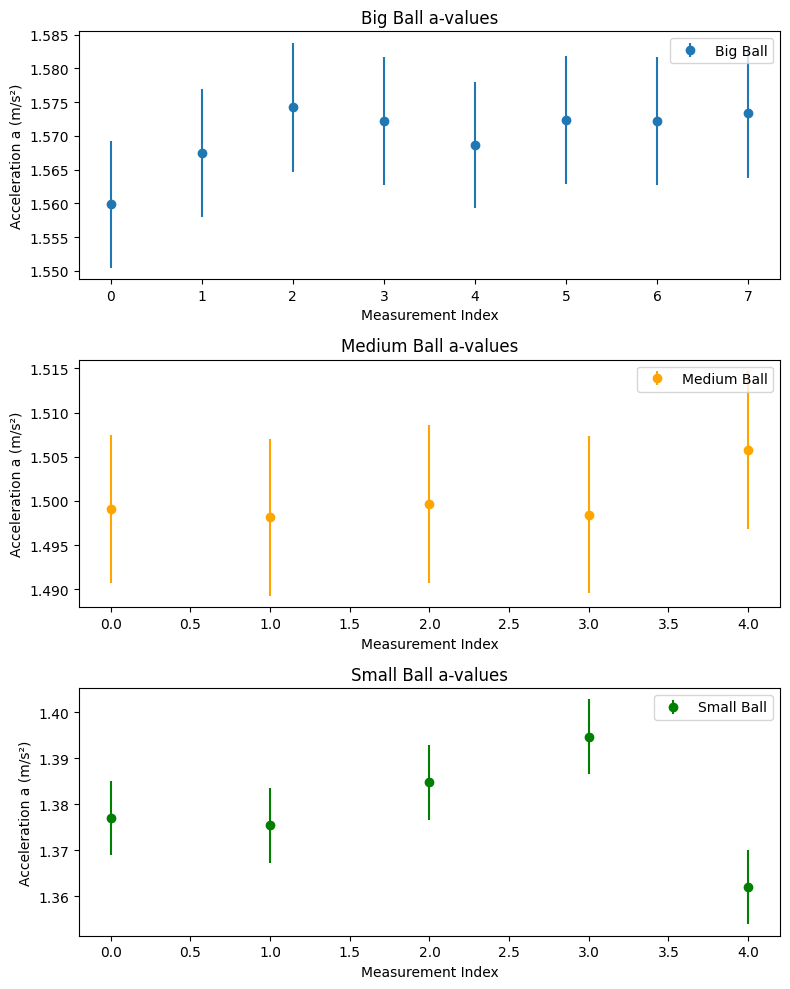

In [232]:

figs, axs = plt.subplots(3, 1, figsize=(8, 10))
axs[0].errorbar(range(len(a_big)), a_big, yerr=a_big_err, fmt='o', label='Big Ball')
axs[0].set_title('Big Ball a-values')
axs[1].errorbar(range(len(a_med)), a_med, yerr=a_med_err, fmt='o', label='Medium Ball', color='orange')
axs[1].set_title('Medium Ball a-values')
axs[2].errorbar(range(len(a_small)), a_small, yerr=a_small_err, fmt='o', label='Small Ball', color='green')
axs[2].set_title('Small Ball a-values')
for ax in axs:
    ax.set_xlabel('Measurement Index')
    ax.set_ylabel('Acceleration a (m/s²)')
    ax.legend()
plt.tight_layout()
plt.show()

Mean measurement σx: 0.0004347490658311758
Mean time-propagated σx: 0.00024393250527695383


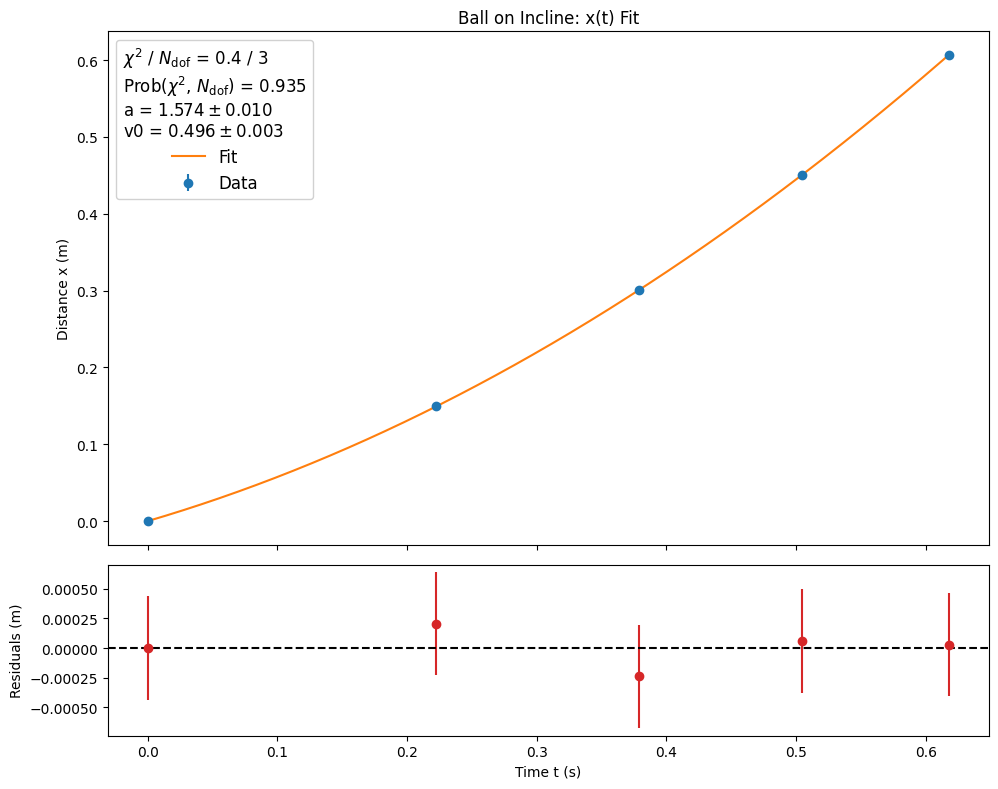

In [233]:
weighted_mean = np.array([8.45567020250723,23.390549662487942,38.54252651880424 ,53.46890067502411,69.1189006750241  ])*0.01
weighted_mean_err = np.array([0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758,0.04347490658311758])*0.01

time, voltage = read_csv('ball_big_3.csv')
timepass1, timepass_sig = find_midpoints(time, voltage, show_plot=False)

t = timepass1-timepass1[0]  # set t=0 at first passing
x = weighted_mean 
sx =weighted_mean_err
timepass_sig = timepass_sig
mfit = fit(x, sx, timepass1, timepass_sig)
print("Mean measurement σx:", np.mean(weighted_mean_err))
print("Mean time-propagated σx:", np.mean(np.abs(0.5 + 1.6 * t) * timepass_sig))

# Plot fit curve
t_fit = np.linspace(min(t), max(t), 1000)
x_fit = model(t_fit, *mfit.values)

x_fit_at_data = model(t, *mfit.values)

residuals = ((x-x[0]) - x_fit_at_data)  # residuals in y

fig, (ax_main, ax_res) = plt.subplots(2, 1, figsize=(10, 8), 
                                      gridspec_kw={'height_ratios': [3, 1]},
                                      sharex=True)

# Main data + fit
ax_main.errorbar(t, x - x[0], yerr=sx, fmt='o', label='Data')
ax_main.plot(t_fit, x_fit, '-', label='Fit')

ax_main.set_ylabel('Distance x (m)')
ax_main.set_title('Ball on Incline: x(t) Fit')
ax_main.tick_params(labelbottom=False)  # hide x-tick labels on top plot

# Residuals
ax_res.errorbar(t, residuals, yerr=sx, fmt='o', color='tab:red')
ax_res.axhline(0, color='black', linestyle='--')
ax_res.set_xlabel('Time t (s)')
ax_res.set_ylabel('Residuals (m)')

# ------------------------------
# CHI-SQUARE + p-value
# ------------------------------
chi2 = mfit.fval                          
Ndof = len(x) - len(mfit.values)          
p_value = stats.chi2.sf(chi2, Ndof)       

fit_info = [
    rf"$\chi^2$ / $N_\mathrm{{dof}}$ = {chi2:.1f} / {Ndof}",
    rf"Prob($\chi^2$, $N_\mathrm{{dof}}$) = {p_value:.3f}",
]

# Parameters + uncertainties
for p, v, e in zip(mfit.parameters, mfit.values, mfit.errors):
    Ndec = max(0, -int(np.log10(e) - 1 - np.log10(2)))
    fit_info.append(
        f"{p} = ${v:{10}.{Ndec}f} \\pm {e:{10}.{Ndec}f}$"
    )

# Single legend in top-left of main plot
ax_main.legend(title="\n".join(fit_info),
               loc='upper left',
               fontsize=12,
               title_fontsize=12,
               framealpha=0.9)

fig.tight_layout()
plt.show()

In [234]:
print(residuals)
print(x_fit_at_data)
print(x)

[ 0.00000000e+00  2.03131569e-04 -2.39146765e-04  5.88296030e-05
  2.88268403e-05]
[0.         0.14914566 0.30110771 0.45007348 0.60660348]
[0.0845567  0.2339055  0.38542527 0.53468901 0.69118901]


So weird things happen here with ball size vs the reversed. If there was some angle inherent in the system, we would expect that the deviation would go in the same direction, but here it seems to go both ways. This could be explained by the uncertainties being a bit to small, thus inflating the sigmas, and then it might just be slight deviations where the angle is close to 0. then the big ball is a lot closer to its reversed, dont know why. 

In [235]:
# print all a

print("Big Ball a values:", a_big_wmean,a_big_wmean_err)
print("Medium Ball a values:", a_med_wmean,a_med_wmean_err)
print("Small Ball a values:", a_small_wmean,a_small_wmean_err)
print("Big Ball Reversed a values:", a_big_rev_wmean,a_big_rev_wmean_err)
print("Medium Ball Reversed a values:", a_med_rev_wmean,a_med_rev_wmean_err)
print("Small Ball Reversed a values:", a_small_rev_wmean,a_small_rev_wmean_err)



Big Ball a values: 1.5699888552666121 0.003345375805102213
Medium Ball a values: 1.5001911554283103 0.00393104206313058
Small Ball a values: 1.3787015130692102 0.0036183358104062576
Big Ball Reversed a values: 1.5754624307497502 0.004240356041541436
Medium Ball Reversed a values: 1.5016157150640974 0.003972835309345796
Small Ball Reversed a values: 1.3771578604111745 0.0035864223450069654


In [236]:
# ### COMBINE RESULTS ###
# a_combined = np.array([a_big_wmean, a_med_wmean, a_small_wmean,
#                        a_big_rev_wmean, a_med_rev_wmean, a_small_rev_wmean])
# a_combined_err = np.array([a_big_wmean_err, a_med_wmean_err, a_small_wmean_err,
#                            a_big_rev_wmean_err, a_med_rev_wmean_err, a_small_rev_wmean_err])
# a,a_err = weighted_mean(a_combined, a_combined_err)

# if blinded:
#     a_final = a + r.normal(0, 0.2)
# else:
#     a_final = a

# print("Final combined a =", a_final, "±", a_err)

In [237]:

# a_values_big_ball = []
# a_errors_big_ball = []
# for file in big_ball_files:
#     mfit = main(file)
#     a = mfit.values["a"]
#     a_err = mfit.errors["a"]
#     a_values_big_ball.append(a)
#     a_errors_big_ball.append(a_err)
# #     print(f"{file}: a={a}")
# #     print(f"{file}: a_err={a_err}")


# a, a_err = weighted_mean(a_values_big_ball, a_errors_big_ball)
# if blinded:
#         a_final = a +r.normal(0, 0.2)

# else:
#         a_final = a
# print(f'Big ball weighted mean a: {a_final} ± {a_err}')

# if blinded:
#         a_final = a +r.normal(0, 0.05, size=timepass.shape)
# else:
#         a_final = a
# print(f'{a_final}')

In [238]:
def weighted_mean(a,s):
    """Compute weighted mean and its uncertainty"""
    a = np.asarray(a, dtype=float)
    s = np.asarray(s, dtype=float)
    w = 1 / s**2
    wmean = np.sum(w * a) / np.sum(w)
    wmean_err = np.sqrt(1 / np.sum(w)) 
    return wmean, wmean_err
slope_angle = [
    (90-75.9, 0.06),
    (90-76.1, 0.05), 
    (90-75.8, 0.08), 
    (90-75.9, 0.1), 
    (90-75.9, 0.06),
    (90-76.2, 0.06), 
    (90-76.1, 0.08), 
    (90-76.08, 0.1) 
]

diameter_ball_big = [
    (15, 0.05),
    (14.8, 0.1),
    (14.9, 0.15),
    (14.8, 0.2),
    (14.9, 0.1)
]
diameter_rail = [
    (6, 0.05),
    (5.9, 0.1),
    (5.9, 0.15),
    (6.0, 0.1),
    (6.0, 0.08)
]

datasets = {
    "diameter_ball_big": diameter_ball_big,
    "slope_angle": slope_angle,
    "diameterrail": diameter_rail
}
theta_deg_list = np.array([angle for angle, err in datasets["slope_angle"]])
theta_deg_err_list = np.array([err for angle, err in datasets["slope_angle"]])


theta_mean_deg, theta_err_deg = weighted_mean(theta_deg_list, theta_deg_err_list)
theta_mean = theta_mean_deg * np.pi / 180.0
theta_err = theta_err_deg * np.pi / 180.0

D_ball = np.mean([d for d, err in datasets["diameter_ball_big"]])
d_rail = np.mean([d for d, err in datasets["diameterrail"]])

In [239]:
g_plus  = a_big_wmean / np.sin(theta_mean + theta_err) * (1 + (2/5) * (D_ball**2 / (D_ball**2 - d_rail**2)))
g_minus = a_big_wmean / np.sin(theta_mean - theta_err) * (1 + (2/5) * (D_ball**2 / (D_ball**2 - d_rail**2)))

print("g plus:", g_plus)
print("g minus:", g_minus)



g plus: 9.574096007338781
g minus: 9.6062604211774


# What to do next?

From the V(t) data you should be able to determine five times at which the ball passed. Discuss in the group how to do this best, and possibly test it by seeing if the result is "invariant" between different data sets.

Note that getting an uncertainty can be hard, and think about the relevance of such an uncertainty, which should anyway be rather small.